# Import Torch and enable gpu

In [3]:
import torch 
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision

In [5]:
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
image_path = "./data/hazelnut/train/good/000.png"
image = Image.open(image_path)
print(image.size)

(1024, 1024)


In [9]:
transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image = transforms(image)

torch.Size([3, 224, 224])


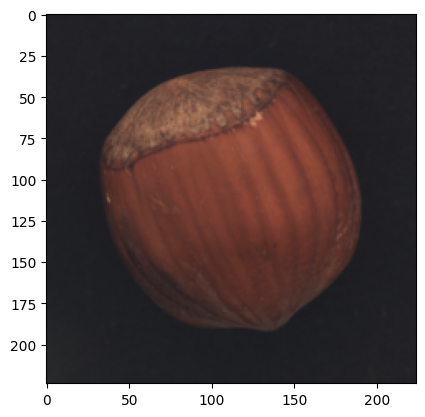

In [10]:
print(image.shape)
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

# Memory

In [61]:
memory_usage = image.numel() * image.element_size()
print(f"Memory usage: {memory_usage / (1024 ** 2):.2f} MB")
print(f'Memory for all 208 images: {memory_usage * 208 / (1024 ** 2):.2f} MB')

Memory usage: 0.57 MB
Memory for all 208 images: 119.44 MB


In [19]:
train_image_folder = ImageFolder(root="./data/hazelnut/train", transform=transforms)
x, y = train_image_folder[0]
print(f"Image shape: {x.shape}, Label: {y}")

Image shape: torch.Size([3, 224, 224]), Label: 0


In [20]:
train_dataset,val_dataset = torch.utils.data.random_split(train_image_folder, [0.8, 0.2])
print(f"Train dataset size: {len(train_dataset)}")

Train dataset size: 313


# Dataloading


In [21]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

image_batch, labels = next(iter(train_loader))
print(f"Batch image shape: {image_batch.shape}, Batch labels shape: {labels.shape}")

memory_usage_batch = image_batch.numel() * image_batch.element_size()
print(f"Memory usage for batch: {memory_usage_batch / (1024 ** 2):.2f} MB")

Batch image shape: torch.Size([16, 3, 224, 224]), Batch labels shape: torch.Size([16])
Memory usage for batch: 9.19 MB


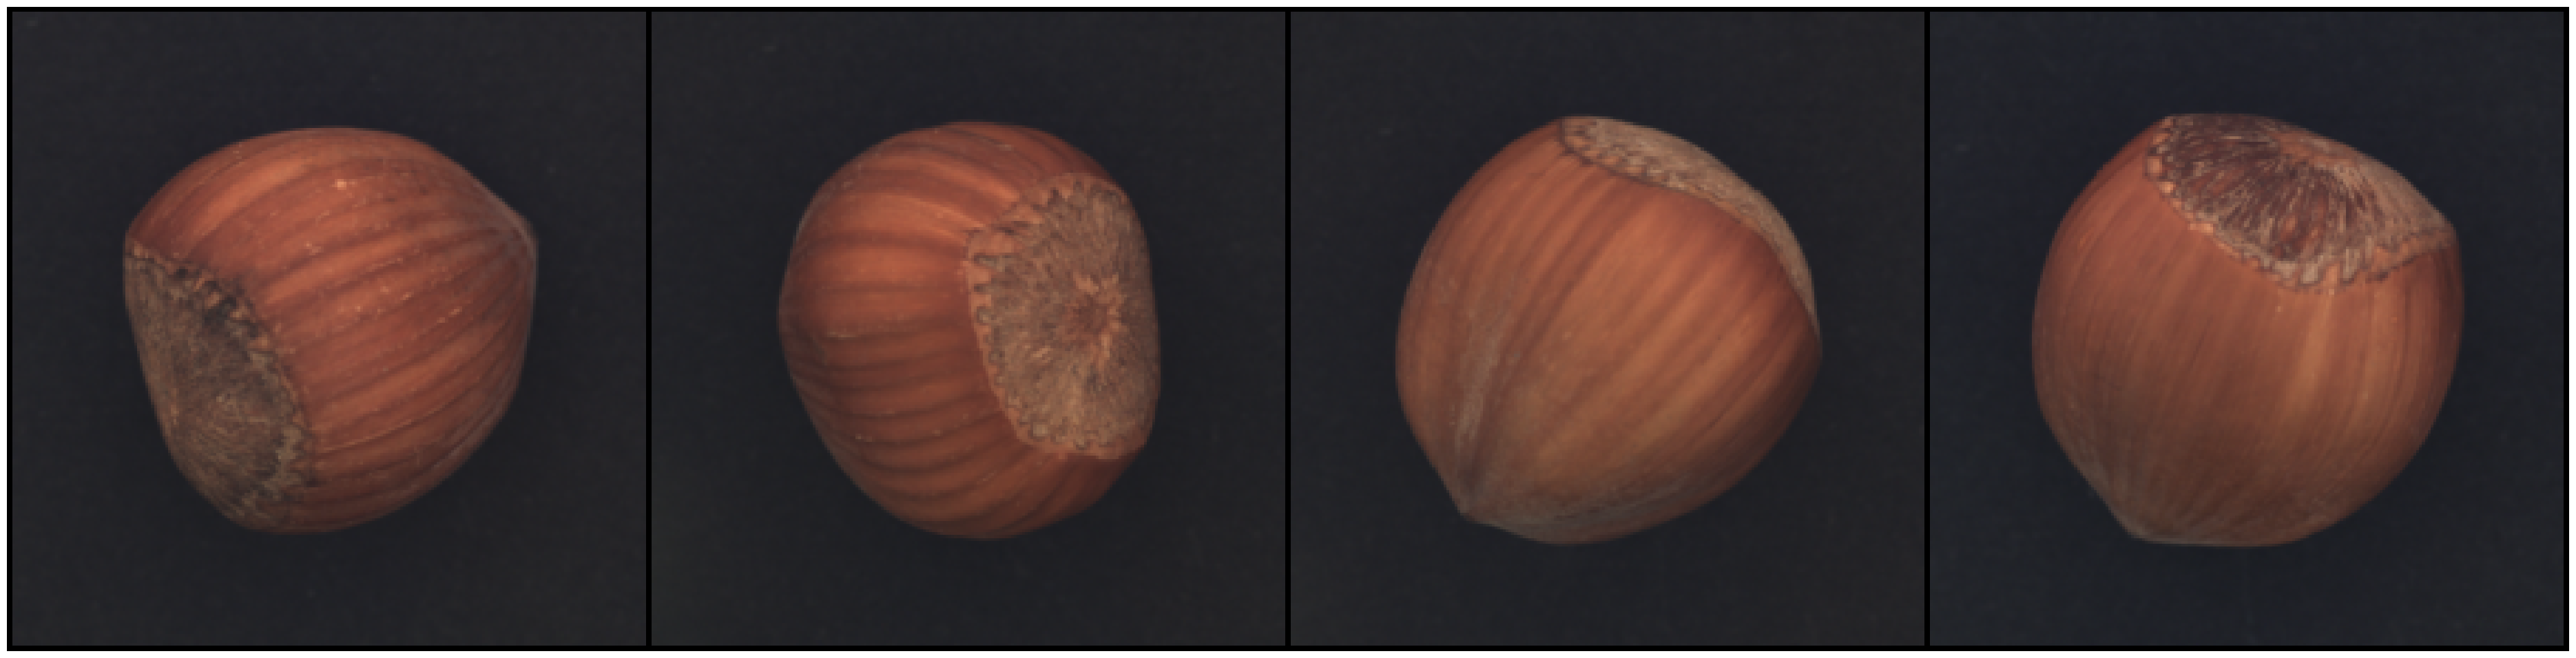

In [65]:
plt.figure(figsize=(12*4, 8*4))
grid_size = torchvision.utils.make_grid(image_batch[0:4], nrow=4)
plt.imshow(np.transpose(grid_size.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [12]:
input_image = Image.open(r'.\data\hazelnut\train\good\000.png')
input_image = transforms(input_image) 

input_image = input_image.unsqueeze(0) 

c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
x = c1(input_image)
print(x.shape)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2 )
x= ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3 )
ap3 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap3(c3(x))
print(x.shape)

c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1 )
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1 )
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1 )
x = c6(x)
print(x.shape)

torch.Size([1, 128, 221, 221])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


In [13]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()  
input_image = torch.randn(1, 3, 224, 224) 
output_image = model(input_image)
print(output_image.shape)  

torch.Size([1, 3, 224, 224])


In [14]:
ckpoints = torch.load('simple_autoencoder_l2_loss.pth')
model.load_state_dict(ckpoints)

model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

  1%|          | 1/100 [00:20<34:27, 20.88s/it]

Epoch [1/100], Loss: 0.0023, Validation Loss: 0.0022


  6%|▌         | 6/100 [03:24<58:21, 37.25s/it]

Epoch [6/100], Loss: 0.0011, Validation Loss: 0.0011


 11%|█         | 11/100 [06:46<1:00:28, 40.77s/it]

Epoch [11/100], Loss: 0.0009, Validation Loss: 0.0009


 16%|█▌        | 16/100 [10:04<55:01, 39.30s/it]  

Epoch [16/100], Loss: 0.0009, Validation Loss: 0.0009


 21%|██        | 21/100 [12:53<42:34, 32.33s/it]

Epoch [21/100], Loss: 0.0008, Validation Loss: 0.0008


 26%|██▌       | 26/100 [14:59<35:46, 29.01s/it]

Epoch [26/100], Loss: 0.0008, Validation Loss: 0.0007


 31%|███       | 31/100 [18:07<40:51, 35.52s/it]

Epoch [31/100], Loss: 0.0007, Validation Loss: 0.0007


 36%|███▌      | 36/100 [21:07<38:20, 35.95s/it]

Epoch [36/100], Loss: 0.0007, Validation Loss: 0.0006


 41%|████      | 41/100 [24:07<35:16, 35.87s/it]

Epoch [41/100], Loss: 0.0006, Validation Loss: 0.0006


 46%|████▌     | 46/100 [27:06<32:18, 35.89s/it]

Epoch [46/100], Loss: 0.0005, Validation Loss: 0.0005


 51%|█████     | 51/100 [30:03<29:11, 35.75s/it]

Epoch [51/100], Loss: 0.0005, Validation Loss: 0.0005


 56%|█████▌    | 56/100 [31:38<15:20, 20.92s/it]

Epoch [56/100], Loss: 0.0005, Validation Loss: 0.0005


 61%|██████    | 61/100 [34:29<22:04, 33.96s/it]

Epoch [61/100], Loss: 0.0004, Validation Loss: 0.0004


 66%|██████▌   | 66/100 [37:27<19:05, 33.68s/it]

Epoch [66/100], Loss: 0.0004, Validation Loss: 0.0004


 71%|███████   | 71/100 [40:23<17:24, 36.02s/it]

Epoch [71/100], Loss: 0.0004, Validation Loss: 0.0004


 76%|███████▌  | 76/100 [43:32<15:06, 37.78s/it]

Epoch [76/100], Loss: 0.0003, Validation Loss: 0.0003


 81%|████████  | 81/100 [45:13<07:00, 22.14s/it]

Epoch [81/100], Loss: 0.0003, Validation Loss: 0.0003


 86%|████████▌ | 86/100 [46:49<04:50, 20.77s/it]

Epoch [86/100], Loss: 0.0003, Validation Loss: 0.0003


 91%|█████████ | 91/100 [48:14<02:37, 17.50s/it]

Epoch [91/100], Loss: 0.0003, Validation Loss: 0.0003


 96%|█████████▌| 96/100 [49:41<01:08, 17.05s/it]

Epoch [96/100], Loss: 0.0002, Validation Loss: 0.0002


100%|██████████| 100/100 [50:50<00:00, 30.50s/it]


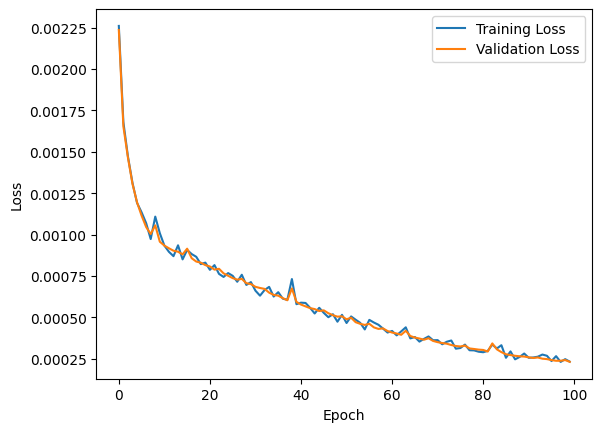

In [ ]:


from tqdm import tqdm
Loss = []
Validation_Loss = []


num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()  
    for img, _ in train_loader:
        img = img.cuda()
        
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
    Loss.append(loss.item())
           
    model.eval()  
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in val_loader:
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

torch.save(model.state_dict(), 'simple_autoencoder_l2_loss.pth')
model.eval()

ckpoints = torch.load('simple_autoencoder_l2_loss.pth')
model.load_state_dict(ckpoints)

<All keys matched successfully>

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

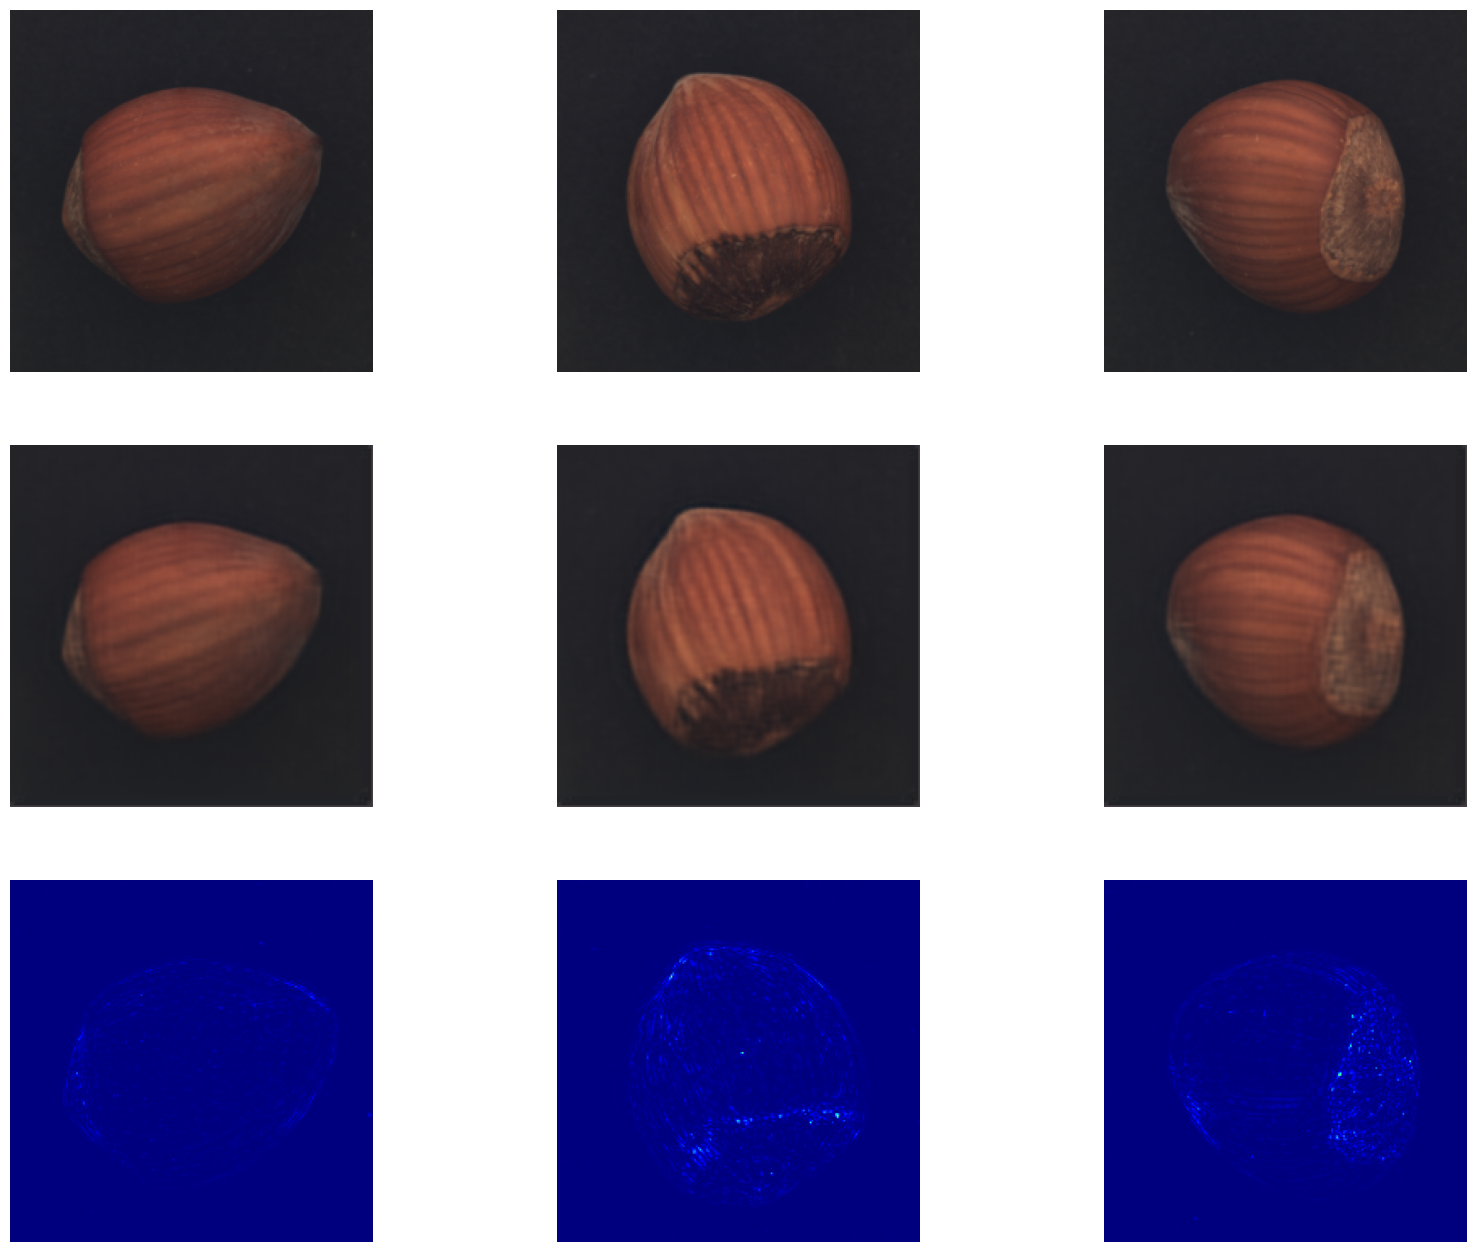

In [22]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

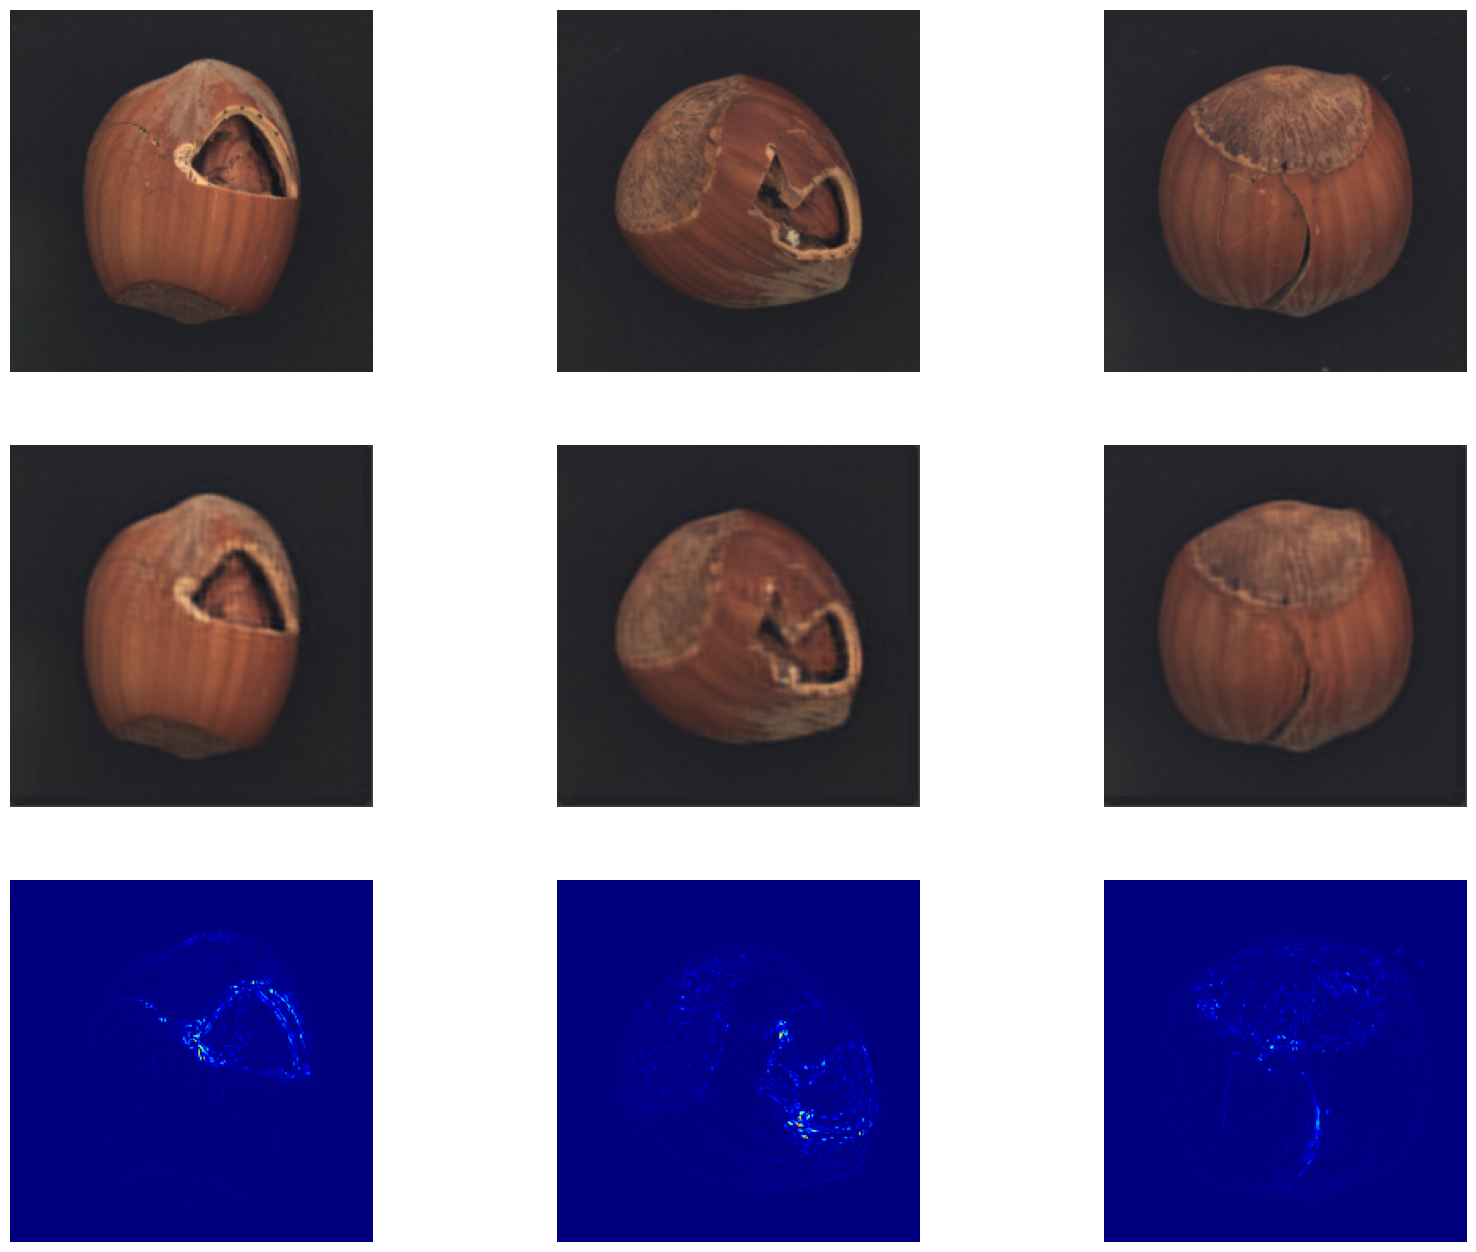

In [23]:
test_image_1 = transforms(Image.open(r'data\hazelnut\test\crack\000.png'))
test_image_2 = transforms(Image.open(r'data\hazelnut\test\crack\001.png'))
test_image_3 = transforms(Image.open(r'data\hazelnut\test\crack\002.png'))

data = torch.stack([test_image_1,test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)
    
recon_error =  ((data-recon)**2).mean(axis=1)
    
plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()